# Recommendation System for MarketPlace Apparel Products

- Comparação de funções de agregação para representações de imagem e texto

Edvaldo Santos, 11/2024


---
### Setup

In [4]:
# !pip install unidecode session_info

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 kB 5.4 MB/s eta 0:00:00
  Created wheel for session_info: filename=session_info-1.0.0-py3-none-any.whl size=8023 sha256=5d2fa2a0f91674b9ca5f882ca48c1a0c806472963f97a5f01a5f3a85988a4f37
  Stored in directory: /root/.cache/pip/wheels/6a/aa/b9/eb5d4031476ec10802795b97ccf937b9bd998d68a9b268765a
Successfully built session_info


In [19]:
# from google.colab import drive
# drive.mount('/content/drive')


Mounted at /content/drive


In [20]:
# import tarfile

# # Defina o caminho do arquivo .tar.gz
# path_to_tar = '/content/drive/MyDrive/item_thumbs.tar.gz'

# # Extraia o conteúdo
# with tarfile.open(path_to_tar, 'r:gz') as tar:
#     tar.extractall('/content')  # Pasta de destino para extrair as imagens

In [5]:
# Importação das bibliotecas necessárias
import string
from unidecode import unidecode
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse.linalg import svds
from PIL import Image
import matplotlib.pyplot as plt
import os

import session_info

In [6]:
session_info.show(html=False)

-----
PIL                 10.4.0
matplotlib          3.8.0
numpy               1.26.4
pandas              2.2.2
scipy               1.13.1
session_info        1.0.0
sklearn             1.5.2
unidecode           NA
-----
IPython             7.34.0
jupyter_client      6.1.12
jupyter_core        5.7.2
notebook            6.5.5
-----
Python 3.10.12 (main, Sep 11 2024, 15:47:36) [GCC 11.4.0]
Linux-6.1.85+-x86_64-with-glibc2.35
-----
Session information updated at 2024-11-03 16:59


---
### Functions

In [7]:
# Função para carregar e achatar as imagens
def carregar_e_achatar_imagens(df, modo_cor='rgb', tamanho_imagem=(64, 64)):
    imagens = []
    ids = []
    for idx, row in df.iterrows():
        caminho_img = row['thumbnail_path']
        try:
            # Abre a imagem do caminho especificado
            img = Image.open(caminho_img)
            # Redimensiona a imagem para um tamanho padrão para uniformizar
            img = img.resize(tamanho_imagem)
            if modo_cor == 'grayscale':
                # Converte a imagem para escala de cinza
                img = img.convert('L')
                # Converte a imagem em um array numpy e achata em um vetor 1D
                img_array = np.array(img).flatten()
            else:
                # Garante que a imagem está em modo RGB
                img = img.convert('RGB')
                # Converte a imagem em um array numpy e achata em um vetor 1D
                img_array = np.array(img).flatten()
            # Adiciona o vetor de imagem à lista de imagens
            imagens.append(img_array)
            # Armazena o item_id correspondente
            ids.append(row['item_id'])
        except Exception as e:
            # Em caso de erro ao carregar a imagem, imprime o erro e continua
            print(f"Erro ao carregar a imagem {caminho_img}: {e}")
            continue
    # Retorna um array numpy das imagens e a lista de ids
    return np.array(imagens), ids

In [8]:
def clean_text(text: str) -> str:
    """
    Method to clean up and stardarize text data
    """

    # Convert to lower case
    text = text.lower()
    # Remove accent
    text = unidecode(text)
    # Remove ponctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove digits
    text = ''.join([i for i in text if not i.isdigit()])
    # Remove spaces
    text = text.strip()

    return text

---
### Read and Process Data

In [9]:
sample_items_meli = pd.read_csv('sample_items_meli.csv')

In [10]:
sample_items_meli.shape

(15270, 5)

In [11]:
categorias_distintas = len(set(sample_items_meli['ITE_ITEM_DOM_DOMAIN_ID']))
categorias_distintas

832

In [54]:
# Removing domains with few orders using cumulative sum (threshold = 55%)
# value obtained by testing some thresholds and checking the remaining domains till it gets more domains related to clothing or makeup
domain_vc = sample_items_meli.ITE_ITEM_DOM_DOMAIN_ID.value_counts().reset_index()
domain_vc.loc[:, "cum_sum"] = domain_vc.loc[:, "count"].cumsum()
domain_vc["%_acum"] = domain_vc.loc[:, "cum_sum"] / domain_vc.loc[:, "count"].sum()
domains_to_keep = domain_vc[domain_vc["%_acum"]<=0.55]["ITE_ITEM_DOM_DOMAIN_ID"].values
sample_items_meli_mod = sample_items_meli[sample_items_meli.ITE_ITEM_DOM_DOMAIN_ID.isin(domains_to_keep)].reset_index(drop=True)

In [55]:
# Remover duplicados da base de dados
sample_items_meli_mod = sample_items_meli_mod.drop_duplicates(subset='item_id')

In [56]:
# Clean item title
sample_items_meli_mod.loc[:, "clean_title"] = sample_items_meli_mod.loc[:, "ITE_ITEM_TITLE"].apply(clean_text)

In [57]:
sample_items_meli_mod.shape, len(set(sample_items_meli_mod['ITE_ITEM_DOM_DOMAIN_ID']))

((7256, 6), 54)

In [58]:
len(set(sample_items_meli_mod['ITE_ITEM_DOM_DOMAIN_ID']))

54

In [59]:
sample_items_meli_mod.head()

,item_id,ITE_ITEM_TITLE,ITE_ITEM_DOM_DOMAIN_ID,buyer_ID,thumbnail_path,clean_title
0,MLB2619201839,Sandália Infantil Feminina Chinelo Flamingo Mo...,MLB-SANDALS_AND_CLOGS,1375,item_thumbs/877474-MLB49725310569_042022.jpeg,sandalia infantil feminina chinelo flamingo mo...
1,MLB3751098364,Spot Trilho Duplo 2 Sobrepor Direcionável E-27...,MLB-WALL_AND_CEILING_LIGHTS,1380,item_thumbs/849578-MLU77154677816_072024.jpeg,spot trilho duplo sobrepor direcionavel e bra...
2,MLB3079601422,Umidificador Ar Portatil Ultrassonico Britania...,MLB-ELECTRIC_OIL_DIFFUSERS_HUMIDIFIERS_AND_VAP...,2593,item_thumbs/653292-MLB51210265777_082022.jpeg,umidificador ar portatil ultrassonico britania...
3,MLB3095457794,Sapato Mocassim Loafer Beira Rio Conforto Orig...,MLB-LOAFERS_AND_OXFORDS,3849,item_thumbs/814106-MLB53091315903_122022.jpeg,sapato mocassim loafer beira rio conforto orig...
4,MLB4667345894,Touca Gorro Cirúrgica Enfermagem Lilo & Stitch,MLB-HATS_AND_CAPS,4422,item_thumbs/981304-MLB78213957830_082024.jpeg,touca gorro cirurgica enfermagem lilo stitch


In [27]:
sample_items_meli_mod.columns

Index(['item_id', 'ITE_ITEM_TITLE', 'ITE_ITEM_DOM_DOMAIN_ID', 'buyer_ID',
       'thumbnail_path', 'clean_title'],
      dtype='object')

In [60]:
# Split in train and test
# train set: pool of itens to generate similar itens
# test set: pool of itens to use as seem by the buyer while browsing

train, test = train_test_split(sample_items_meli_mod,
                               test_size=0.1,
                               stratify=sample_items_meli_mod.ITE_ITEM_DOM_DOMAIN_ID,
                               random_state=42)

In [61]:
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

---
### Analysis

##### Items Similarity

- Creating Image Embeddings

In [62]:
#### TRAIN
# Carrega e achata as imagens em RGB
train_images, _ = carregar_e_achatar_imagens(train, modo_cor='rgb', tamanho_imagem=(120, 120))
# Standarizing images
scaler = StandardScaler()
train_images_sc = scaler.fit_transform(train_images)
# Apply PCA to reduce image vector sizes
pca = PCA(n_components=1000)
train_images_pca = pca.fit_transform(train_images_sc)

In [63]:
#### TEST
# Carrega e achata as imagens em RGB
test_images, _ = carregar_e_achatar_imagens(test, modo_cor='rgb', tamanho_imagem=(120, 120))
# Standarizing images
test_images_sc = scaler.transform(test_images)
# Apply PCA to reduce image vector sizes
test_images_pca = pca.transform(test_images_sc)

In [64]:
train_images_pca.shape, test_images_pca.shape

((6530, 1000), (726, 1000))

- Creating Text Embeddings

In [65]:
##### TRAIN
# Create tf idf vectors
text_vec = TfidfVectorizer(max_features=5000)
tf_idf_train = text_vec.fit_transform(train.clean_title)
# Apply PCA to reduce dimensionality and sparsity
pca_text = PCA(n_components=500)
tf_idf_train_pca = pca_text.fit_transform(tf_idf_train)

In [66]:
##### TEST
# Create tf idf vectors
tf_idf_test = text_vec.transform(test.clean_title)
# Apply PCA to reduce dimensionality and sparsity
tf_idf_test_pca = pca_text.transform(tf_idf_test)

In [67]:
tf_idf_train_pca.shape, tf_idf_test_pca.shape

((6530, 500), (726, 500))

### Comparação Funções de Agregação

#### Funções

In [68]:
# Precisão@k (Top-k Accuracy)
# Para cada item no conjunto de teste, classifique os itens no conjunto de treinamento com base na pontuação de similaridade agregada.
# Calcule se os k itens mais similares (por exemplo, top-5 ou top-10) contêm algum item relevante e, em seguida, calcule a média disso em todos os itens de teste.

from sklearn.metrics import precision_score
import numpy as np

def precision_at_k(test_indices, train_indices, sim_scores, k=5):
    precisao_scores = []
    for idx in range(len(test_indices)):
        # Classifique os itens de treinamento pela pontuação de similaridade para cada item de teste
        top_k_indices = np.argsort(sim_scores[idx])[::-1][:k]
        # Conte itens relevantes nos top-k
        itens_relevantes = sum([1 for i in top_k_indices if train_indices[i] == test_indices[idx]])
        precisao_scores.append(itens_relevantes / k)
    return np.mean(precisao_scores), precisao_scores


In [69]:
# A diversidade mede quão distintos os itens recomendados são entre si. Uma alta similaridade pode levar a recomendações muito semelhantes,
# então você pode calcular a distância média entre pares dos itens mais similares (top-k) para verificar a diversidade.

from sklearn.metrics.pairwise import cosine_distances

def diversity_at_k(sim_scores, train_embeddings, k=5):
    diversidades = []
    for idx in range(len(sim_scores)):
        # Obter os índices dos top-k itens mais similares
        top_k_indices = np.argsort(sim_scores[idx])[::-1][:k]
        # Extrair as representações dos embeddings dos itens top-k
        top_k_embeddings = train_embeddings[top_k_indices]
        # Calcular as distâncias entre pares dos itens top-k
        distancias_pares = cosine_distances(top_k_embeddings)
        # Calcular a média das distâncias, excluindo as distâncias para si mesmos
        pontuacao_diversidade = np.mean(distancias_pares[np.triu_indices(k, k=1)])
        diversidades.append(pontuacao_diversidade)
    return np.mean(diversidades)


#### Comparação

In [75]:
# Inicializar listas vazias para armazenar as pontuações de similaridade para cada item de teste
all_sim_scores_weighted_avg = []
all_sim_scores_max = []
all_sim_scores_exponential = []
all_sim_scores_text_only = []
all_sim_scores_img_only = []

# Definir pesos para as similaridades de texto e imagem
alpha = 0.7  # Peso para a similaridade de texto
beta = 1 - alpha  # Peso para a similaridade de imagem

for idx in range(len(test_images_pca)):
    # Calcular a similaridade de imagem e texto para este item de teste com todos os itens de treinamento
    cos_sim_img = cosine_similarity(test_images_pca[idx].reshape(1, -1), train_images_pca)
    cos_sim_text = cosine_similarity(tf_idf_test_pca[idx].reshape(1, -1), tf_idf_train_pca)

    # Estratégias de agregação
    sim_scores_weighted_avg = alpha * cos_sim_text + beta * cos_sim_img
    sim_scores_max = np.maximum(alpha * cos_sim_text, beta * cos_sim_img)
    sim_scores_exponential = np.exp(alpha * cos_sim_text) * (beta * cos_sim_img)

    # Similaridade apenas de texto
    sim_scores_text_only = cos_sim_text

    # Similaridade apenas de imagem
    sim_scores_img_only = cos_sim_img

    # Achatar cada resultado de agregação e armazenar nas listas correspondentes
    all_sim_scores_weighted_avg.append(sim_scores_weighted_avg.flatten())
    all_sim_scores_max.append(sim_scores_max.flatten())
    all_sim_scores_exponential.append(sim_scores_exponential.flatten())
    all_sim_scores_text_only.append(sim_scores_text_only.flatten())
    all_sim_scores_img_only.append(sim_scores_img_only.flatten())

# Empilhar todas as pontuações de similaridade em arrays 2D, uma linha por item de teste
sim_scores_weighted_avg = np.vstack(all_sim_scores_weighted_avg)
sim_scores_max = np.vstack(all_sim_scores_max)
sim_scores_exponential = np.vstack(all_sim_scores_exponential)
sim_scores_text_only = np.vstack(all_sim_scores_text_only)
sim_scores_img_only = np.vstack(all_sim_scores_img_only)

# Dicionário de métodos de agregação para avaliar cada estratégia de agregação
aggregation_methods = {
    'Weighted Average': sim_scores_weighted_avg,
    'Max of Weighted Similarities': sim_scores_max,
    'Exponential Weighting': sim_scores_exponential,
    'Text Only': sim_scores_text_only,
    'Image Only': sim_scores_img_only
}


In [71]:
# Define test and train indices for relevant items, if using category similarity for relevance
test_indices = test['ITE_ITEM_DOM_DOMAIN_ID'].values
train_indices = train['ITE_ITEM_DOM_DOMAIN_ID'].values

In [76]:
# Função para calcular precisão e diversidade para cada método de agregação
def evaluate_aggregation_methods(aggregation_methods, test_indices, train_indices, k=5):
    results = {}

    for method_name, sim_scores in aggregation_methods.items():
        precision, precision_scores = precision_at_k(test_indices, train_indices, sim_scores, k=k)
        diversity = diversity_at_k(sim_scores, train_images_pca, k=k)

        results[method_name] = {
            'Precision': precision,
            'Diversity': diversity
        }

        print(f"{method_name} - Precision@{k}: {precision}, Diversity@{k}: {diversity}")

    return results

# Chamada da função para avaliar os métodos de agregação
evaluation_results = evaluate_aggregation_methods(aggregation_methods, test_indices, train_indices, k=5)


Weighted Average - Precision@5: 0.8165289256198347, Diversity@5: 0.6240105986713951
Max of Weighted Similarities - Precision@5: 0.8258953168044076, Diversity@5: 0.8110200824756483
Exponential Weighting - Precision@5: 0.6099173553719008, Diversity@5: 0.374315306491194
Text Only - Precision@5: 0.8253443526170798, Diversity@5: 0.81128608031018
Image Only - Precision@5: 0.33774104683195594, Diversity@5: 0.32198754753726433


In [77]:
pd.DataFrame(evaluation_results)

,Weighted Average,Max of Weighted Similarities,Exponential Weighting,Text Only,Image Only
Precision,0.816529,0.825895,0.609917,0.825344,0.337741
Diversity,0.624011,0.811020,0.374315,0.811286,0.321988


### Plot 3 test products and recomendations


Top-5 recomendações para o Caso de Teste 3


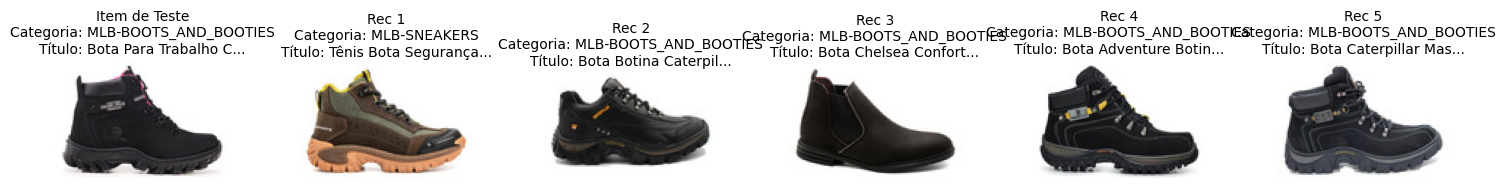


Top-5 recomendações para o Caso de Teste 4


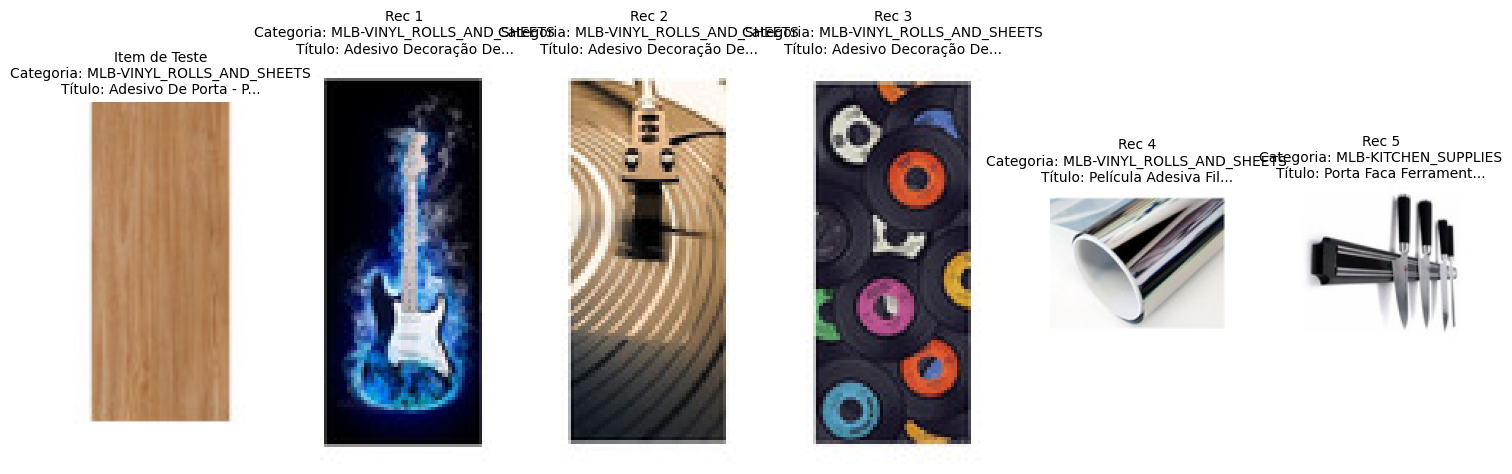


Top-5 recomendações para o Caso de Teste 5


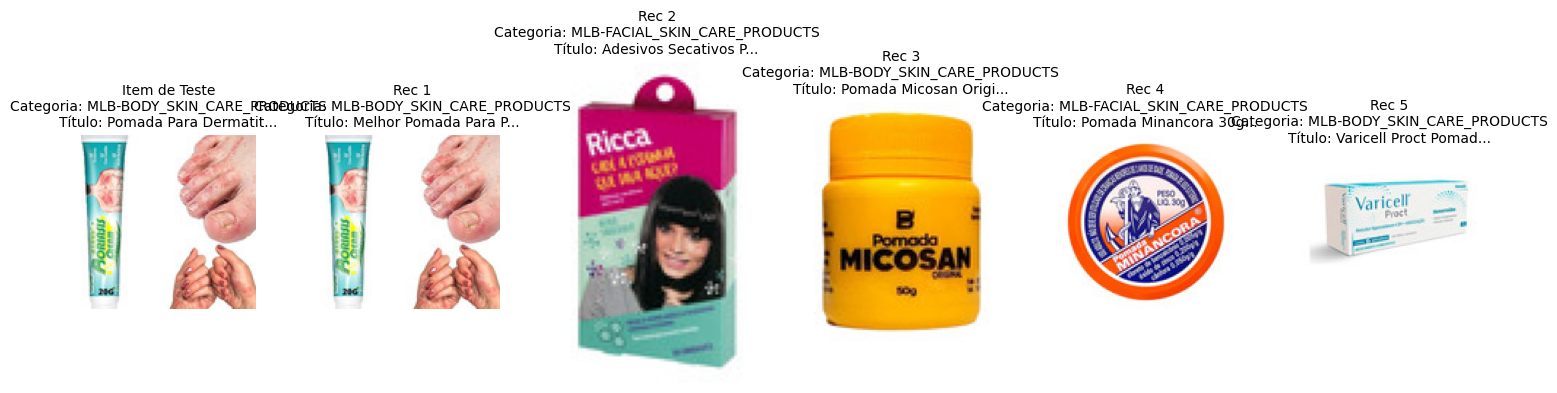

In [82]:
# Definir o valor de k
k = 5
sim_scores = sim_scores_text_only

# Função para plotar um item de teste com suas top-k recomendações
def plot_top_k_examples(test_idx, k=5):
    # Obter o item de teste e sua categoria
    test_item = test.iloc[test_idx]
    test_category = test_item['ITE_ITEM_DOM_DOMAIN_ID']
    test_image_path = test_item['thumbnail_path']
    test_title = test_item['ITE_ITEM_TITLE']

    # Calcular os índices dos top-k com base nas pontuações de similaridade
    top_k_indices = np.argsort(sim_scores[test_idx])[::-1][:k]

    # Plotar o item de teste e suas top-k recomendações
    fig, axs = plt.subplots(1, k+1, figsize=(18, 6))  # Aumentar o tamanho da figura

    # Plotar o item de teste
    axs[0].imshow(plt.imread(test_image_path))
    axs[0].set_title(f"Item de Teste\nCategoria: {test_category}\nTítulo: {test_title[:20]}...", fontsize=10)
    axs[0].axis('off')

    # Plotar as recomendações top-k
    for i, idx in enumerate(top_k_indices):
        recommended_item = train.iloc[idx]
        recommended_category = recommended_item['ITE_ITEM_DOM_DOMAIN_ID']
        recommended_image_path = recommended_item['thumbnail_path']
        recommended_title = recommended_item['ITE_ITEM_TITLE']

        axs[i+1].imshow(plt.imread(recommended_image_path))
        axs[i+1].set_title(f"Rec {i+1}\nCategoria: {recommended_category}\nTítulo: {recommended_title[:20]}...", fontsize=10)
        axs[i+1].axis('off')

    # Ajustar o espaço entre os subplots
    plt.subplots_adjust(wspace=0.4)

    plt.show()

# Testar a função com índices específicos do conjunto de teste
for test_idx in [3, 4, 5]:  # Verificar os primeiros 3 casos de teste
    print(f"\nTop-{k} recomendações para o Caso de Teste {test_idx}")
    plot_top_k_examples(test_idx, k=k)



Top-5 recomendações para o Caso de Teste 3


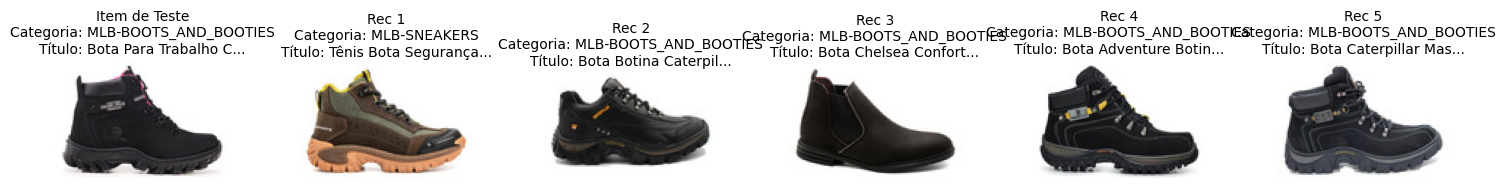


Top-5 recomendações para o Caso de Teste 4


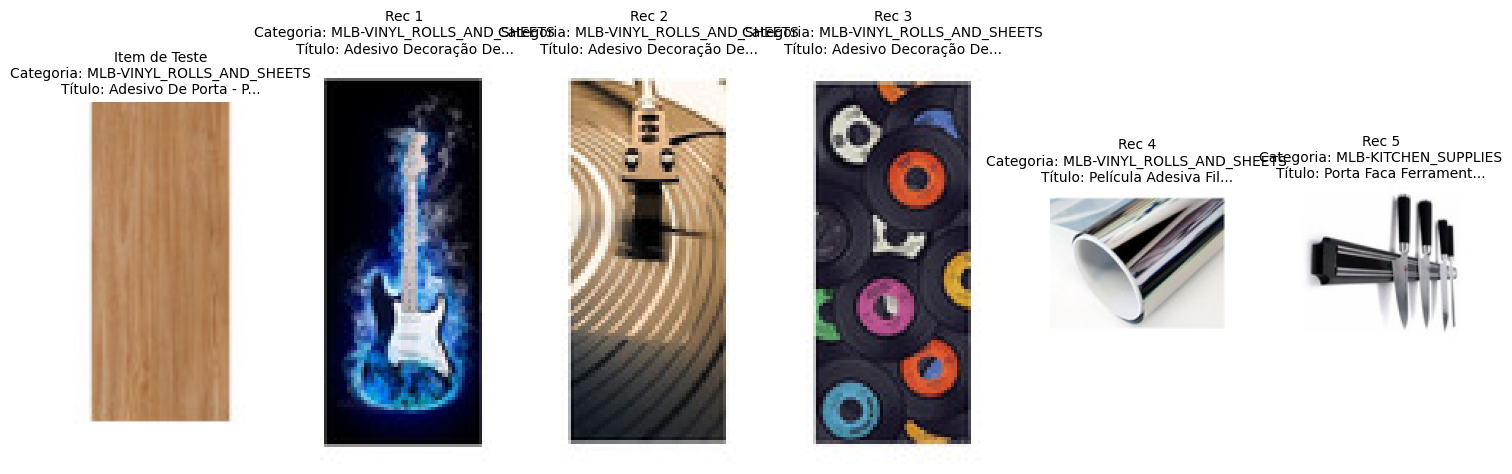


Top-5 recomendações para o Caso de Teste 5


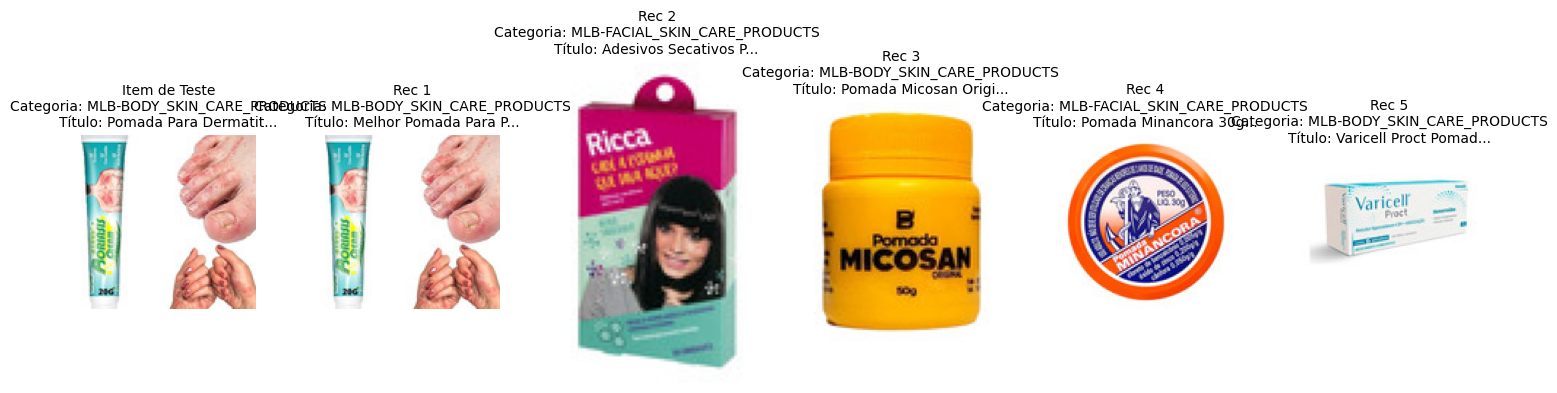

In [83]:
# Set k value
k = 5
sim_scores = sim_scores_max

# Função para plotar um item de teste com suas top-k recomendações
def plot_top_k_examples(test_idx, k=5):
    # Obter o item de teste e sua categoria
    test_item = test.iloc[test_idx]
    test_category = test_item['ITE_ITEM_DOM_DOMAIN_ID']
    test_image_path = test_item['thumbnail_path']
    test_title = test_item['ITE_ITEM_TITLE']

    # Calcular os índices dos top-k com base nas pontuações de similaridade
    top_k_indices = np.argsort(sim_scores[test_idx])[::-1][:k]

    # Plotar o item de teste e suas top-k recomendações
    fig, axs = plt.subplots(1, k+1, figsize=(18, 6))  # Aumentar o tamanho da figura

    # Plotar o item de teste
    axs[0].imshow(plt.imread(test_image_path))
    axs[0].set_title(f"Item de Teste\nCategoria: {test_category}\nTítulo: {test_title[:20]}...", fontsize=10)
    axs[0].axis('off')

    # Plotar as recomendações top-k
    for i, idx in enumerate(top_k_indices):
        recommended_item = train.iloc[idx]
        recommended_category = recommended_item['ITE_ITEM_DOM_DOMAIN_ID']
        recommended_image_path = recommended_item['thumbnail_path']
        recommended_title = recommended_item['ITE_ITEM_TITLE']

        axs[i+1].imshow(plt.imread(recommended_image_path))
        axs[i+1].set_title(f"Rec {i+1}\nCategoria: {recommended_category}\nTítulo: {recommended_title[:20]}...", fontsize=10)
        axs[i+1].axis('off')

    # Ajustar o espaço entre os subplots
    plt.subplots_adjust(wspace=0.4)

    plt.show()

# Testar a função com índices específicos do conjunto de teste
for test_idx in [3, 4, 5]:  # Verificar os primeiros 3 casos de teste
    print(f"\nTop-{k} recomendações para o Caso de Teste {test_idx}")
    plot_top_k_examples(test_idx, k=k)



In [ ]:
# TODO: transformar numa funcao ou classe